# 교통 표지판 분류

![img](https://pyimagesearch.com/wp-content/uploads/2019/11/traffic_sign_recognition_header.jpg)

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [1]:
import matplotlib.pyplot as plt
import glob
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Preprocessing
- Image Size : ( 15x15 ~ 250x250 )
- RGB값으로 학습

In [2]:
N_CLASSES = 43
RESIZE_IMAGE = (32, 32, 3)

def read_trainset_ppm(train_path, n_labels, resize_to):
    images = []
    labels = []
    
    for i in range(n_labels):
        label_path = train_path + '/' + format(i, '05d') + '/'
        
        for img_file in glob.glob(label_path + '*.ppm'):
            img = cv2.imread(img_file)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            if resize_to:
                if resize_to[0] < img.shape[0]:
                    img = cv2.resize(img, (resize_to[0], resize_to[1]), interpolation = cv2.INTER_AREA)
                else:
                    img = cv2.resize(img, (resize_to[0], resize_to[1]), interpolation = cv2.INTER_CUBIC)
                    
            label = np.zeros((n_labels, ), np.float32)
            label[i] = 1.0
            
            images.append(img.astype(np.float32))
            labels.append(label)
            
    x_train = np.array(images, np.float32)
    y_train = np.array(labels, np.float32)
    
    return x_train, y_train


def read_testset_ppm(test_path, resize_to):
    images = []
    labels = []
    
    for img_file in glob.glob(test_path + '/' + '*.ppm'):
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if resize_to:
            if resize_to[0] < img.shape[0]:
                img = cv2.resize(img, (resize_to[0], resize_to[1]), interpolation = cv2.INTER_AREA)
            else:
                img = cv2.resize(img, (resize_to[0], resize_to[1]), interpolation = cv2.INTER_CUBIC)
                    
            images.append(img.astype(np.float32))
            
    labels_path = test_path + '/GT-final_test.csv'
    annotations = pd.read_csv(labels_path, sep = ';')
    
    x_test = np.array(images, np.float32)
    y_test = tf.one_hot(annotations['ClassId'], depth = N_CLASSES).numpy()
    
    return x_test, y_test

- Train : 39209 개 샘플 / Test : 12630 개 샘플

In [3]:
train_path = 'C:/workspace/Data/Traffic-Sign/Train/Images'
test_path = 'C:/workspace/Data/Traffic-Sign/Test/Images'

x_train_orig, y_train_orig = read_trainset_ppm(train_path, N_CLASSES, RESIZE_IMAGE)
x_test_orig, y_test_orig = read_testset_ppm(test_path, RESIZE_IMAGE)

print(x_train_orig.shape, y_train_orig.shape)  ## 총 39209개 데이터, (32, 32, 3) Shape
print(x_test_orig.shape, y_test_orig.shape)    ## 총 12630개 데이터, (32, 32, 3) Shape

(39209, 32, 32, 3) (39209, 43)
(12630, 32, 32, 3) (12630, 43)


## Check

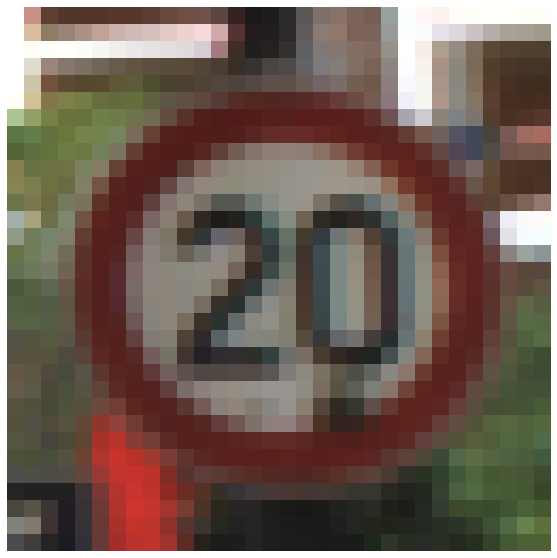

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [4]:
plt.figure(figsize = (10, 10))

plt.imshow(x_train_orig[200].astype(np.uint32))
plt.axis('off')
plt.show()
print(y_train_orig[200])

## Make a Validation-Data Set

In [5]:
idx_train, idx_val = train_test_split(range(x_train_orig.shape[0]), test_size = .2, random_state = 100)

x_train = x_train_orig[idx_train, :, :, :]
y_train = y_train_orig[idx_train, ]

x_val = x_train_orig[idx_val, :, :, :]
y_val = y_train_orig[idx_val, ]

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(31367, 32, 32, 3)
(31367, 43)
(7842, 32, 32, 3)
(7842, 43)


## Normalization

In [6]:
x_train = x_train / 255.0
x_val = x_val / 255.0

# Model 1

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D, Flatten, Input, Dropout
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam

## Modeling

In [8]:
def build_model(input_shape = (32, 32, 3)):
    tf.random.set_seed(8)
    
    model = Sequential([
        Input(shape = input_shape),
        Conv2D(filters = 32, kernel_size = (5, 5), strides = (1, 1), kernel_initializer = glorot_uniform()),
        MaxPooling2D(pool_size = (2, 2)),
        Conv2D(filters = 64, kernel_size = (5, 5), strides = (1, 1), kernel_initializer = glorot_uniform()),
        MaxPooling2D(pool_size = (2, 2)),
        
        Flatten(),
        Dense(1024, activation = 'relu', kernel_initializer = glorot_uniform()),
        Dense(N_CLASSES, activation = 'softmax', kernel_initializer = glorot_uniform())
    ])
    
    model.summary()
    return model

## Compile

In [10]:
model1 = build_model()
model1.compile(optimizer = Adam(lr = 0.001),
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 64)        51264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_2 (Dense)             (None, 1024)             

## Fitting

In [11]:
hist1 = model1.fit(x_train, y_train, batch_size = 256, epochs = 10, validation_data = (x_val, y_val))

Epoch 1/10
123/123 [==============================] - 76s 9ms/step - loss: 1.1095 - acc: 0.7187 - val_loss: 0.2506 - val_acc: 0.9388
Epoch 2/10
123/123 [==============================] - 1s 8ms/step - loss: 0.1749 - acc: 0.9584 - val_loss: 0.1144 - val_acc: 0.9754
Epoch 3/10
123/123 [==============================] - 1s 7ms/step - loss: 0.0769 - acc: 0.9834 - val_loss: 0.0792 - val_acc: 0.9814
Epoch 4/10
123/123 [==============================] - 1s 7ms/step - loss: 0.0344 - acc: 0.9927 - val_loss: 0.0816 - val_acc: 0.9781
Epoch 5/10
123/123 [==============================] - 1s 7ms/step - loss: 0.0356 - acc: 0.9911 - val_loss: 0.0749 - val_acc: 0.9815
Epoch 6/10
123/123 [==============================] - 1s 8ms/step - loss: 0.0193 - acc: 0.9954 - val_loss: 0.0558 - val_acc: 0.9884
Epoch 7/10
123/123 [==============================] - 1s 8ms/step - loss: 0.0135 - acc: 0.9976 - val_loss: 0.0623 - val_acc: 0.9879
Epoch 8/10
123/123 [==============================] - 1s 8ms/step - loss: 0

## Evaluation

In [12]:
model1.evaluate(x_test_orig, y_test_orig)

395/395 [==============================] - 1s 2ms/step - loss: 133.9536 - acc: 0.9131


[133.95358276367188, 0.9131433367729187]

## Plotting

In [14]:
hist1.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

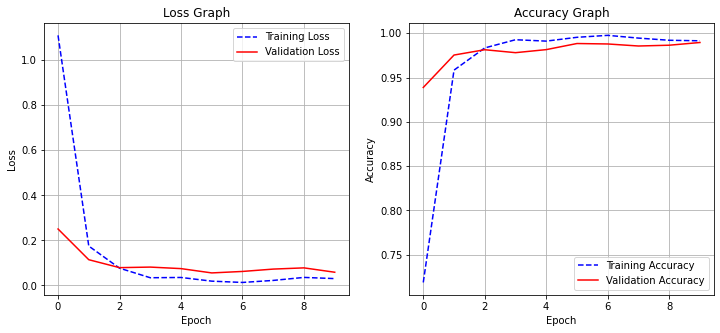

In [21]:
EPOCH = range(10)


plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(EPOCH, hist1.history['loss'], 'b--', label = 'Training Loss')
plt.plot(EPOCH, hist1.history['val_loss'], 'r-', label = 'Validation Loss')
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc = 'best')

plt.subplot(1, 2, 2)
plt.plot(EPOCH, hist1.history['acc'], 'b--', label = 'Training Accuracy')
plt.plot(EPOCH, hist1.history['val_acc'], 'r-', label = 'Validation Accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend(loc = 'best')

plt.show()

# Model2

In [25]:
def build_model2(input_shape = (32, 32, 3)):
    tf.random.set_seed(8)
    
    model = Sequential([
        Input(shape = input_shape),
        Conv2D(filters = 32, kernel_size = (5, 5), strides = (1, 1), kernel_initializer = glorot_uniform()),
        MaxPooling2D(pool_size = (2, 2)),
        Dropout(0.2),
        
        Conv2D(filters = 64, kernel_size = (5, 5), strides = (1, 1), kernel_initializer = glorot_uniform()),
        MaxPooling2D(pool_size = (2, 2)),
        Dropout(0.2),
        
        Flatten(),
        Dense(1024, activation = 'relu', kernel_initializer = glorot_uniform()),
        Dropout(0.4),
        Dense(N_CLASSES, activation = 'relu', kernel_initializer = glorot_uniform())
    ])
    
    model.summary()
    return model

## Compile

In [26]:
model2 = build_model2()
model2.compile(optimizer = Adam(lr = 0.001),
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 28, 28, 32)        2432      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 14, 14, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 64)        51264     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 64)         

## Fitting

In [29]:
hist2 = model2.fit(x_train, y_train, batch_size = 256, epochs = 10, validation_data = (x_val, y_val))

Epoch 1/10
123/123 [==============================] - 1s 10ms/step - loss: 3.9616 - acc: 0.2538 - val_loss: 4.2794 - val_acc: 0.0584
Epoch 2/10
123/123 [==============================] - 1s 9ms/step - loss: 4.2622 - acc: 0.1747 - val_loss: 3.8332 - val_acc: 0.1897
Epoch 3/10
123/123 [==============================] - 1s 9ms/step - loss: 4.3384 - acc: 0.1487 - val_loss: 4.3346 - val_acc: 0.1196
Epoch 4/10
123/123 [==============================] - 1s 9ms/step - loss: 4.6337 - acc: 0.1243 - val_loss: 4.9505 - val_acc: 0.0525
Epoch 5/10
123/123 [==============================] - 1s 9ms/step - loss: 4.9582 - acc: 0.0872 - val_loss: 4.8274 - val_acc: 0.1517
Epoch 6/10
123/123 [==============================] - 1s 9ms/step - loss: 4.8597 - acc: 0.1357 - val_loss: 4.6579 - val_acc: 0.2133
Epoch 7/10
123/123 [==============================] - 1s 9ms/step - loss: 4.8376 - acc: 0.1066 - val_loss: 4.6756 - val_acc: 0.1074
Epoch 8/10
123/123 [==============================] - 1s 9ms/step - loss: 4

## Evaluation

In [28]:
model2.evaluate(x_test_orig, y_test_orig)

395/395 [==============================] - 1s 2ms/step - loss: 4.0781 - acc: 0.1440


[4.0780744552612305, 0.1440221667289734]

## Plotting

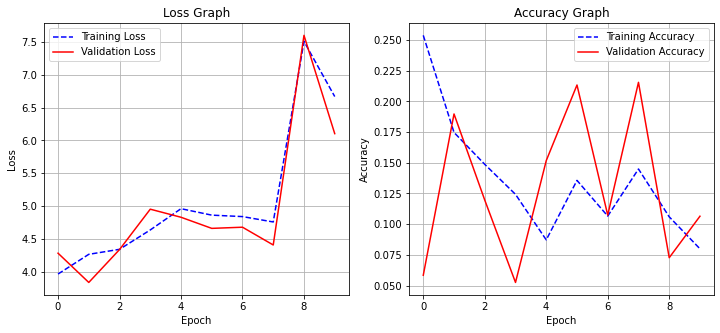

In [30]:
EPOCH = range(10)


plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(EPOCH, hist2.history['loss'], 'b--', label = 'Training Loss')
plt.plot(EPOCH, hist2.history['val_loss'], 'r-', label = 'Validation Loss')
plt.title('Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc = 'best')

plt.subplot(1, 2, 2)
plt.plot(EPOCH, hist2.history['acc'], 'b--', label = 'Training Accuracy')
plt.plot(EPOCH, hist2.history['val_acc'], 'r-', label = 'Validation Accuracy')
plt.title('Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend(loc = 'best')

plt.show()

# Model3 (VGG16)

In [31]:
VGG16_base = tf.keras.applications.VGG16(weights = 'imagenet', include_top = False, input_shape = (32, 32, 3))
VGG16_base.summary()

58900480/58889256 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                              

## Add to Layer in VGG16

In [33]:
def build_model3():
    tf.random.set_seed(8)
    
    model = Sequential([
        Flatten(input_shape = (1, 1, 512)),
        Dense(512, activation = 'relu', kernel_initializer = glorot_uniform()),
        Dropout(0.4),
        Dense(N_CLASSES, activation = 'sigmoid')
    ])
    
    model.compile(optimizer = Adam(lr = 0.001),
                 loss = 'categorical_crossentropy',
                 metrics = ['acc'])
    model.summary()
    return model

model3 = build_model3()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_8 (Dense)             (None, 512)               262656    
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 43)                22059     
                                                                 
Total params: 284,715
Trainable params: 284,715
Non-trainable params: 0
_________________________________________________________________


## Extract prediction

In [34]:
feature_train = VGG16_base.predict(x_train)
feature_test = VGG16_base.predict(x_test_orig)
feature_val = VGG16_base.predict(x_val)

## Fitting

In [35]:
model3.fit(feature_train, y_train, batch_size = 256, epochs = 10, validation_data = (feature_val, y_val))

Epoch 1/10
123/123 [==============================] - 1s 5ms/step - loss: 2.2782 - acc: 0.3502 - val_loss: 1.6804 - val_acc: 0.4997
Epoch 2/10
123/123 [==============================] - 0s 3ms/step - loss: 1.5946 - acc: 0.5103 - val_loss: 1.3836 - val_acc: 0.5904
Epoch 3/10
123/123 [==============================] - 0s 2ms/step - loss: 1.3548 - acc: 0.5805 - val_loss: 1.2143 - val_acc: 0.6385
Epoch 4/10
123/123 [==============================] - 0s 2ms/step - loss: 1.2029 - acc: 0.6250 - val_loss: 1.0833 - val_acc: 0.6667
Epoch 5/10
123/123 [==============================] - 0s 2ms/step - loss: 1.0855 - acc: 0.6595 - val_loss: 0.9983 - val_acc: 0.6980
Epoch 6/10
123/123 [==============================] - 0s 3ms/step - loss: 0.9941 - acc: 0.6875 - val_loss: 0.9168 - val_acc: 0.7221
Epoch 7/10
123/123 [==============================] - 0s 3ms/step - loss: 0.9162 - acc: 0.7140 - val_loss: 0.8705 - val_acc: 0.7343
Epoch 8/10
123/123 [==============================] - 0s 3ms/step - loss: 0.

## VGG16 모델에 추가

In [36]:
tf.random.set_seed(8)

VGG16_model = Sequential([
    VGG16_base,
    Flatten(),
    Dense(512, activation = 'relu', kernel_initializer = glorot_uniform()),
    Dropout(0.4),
    Dense(N_CLASSES, activation = 'softmax', kernel_initializer = glorot_uniform())
])

VGG16_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_5 (Flatten)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 512)               262656    
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 43)                22059     
                                                                 
Total params: 14,999,403
Trainable params: 14,999,403
Non-trainable params: 0
_________________________________________________________________


In [37]:
VGG16_base.trainable = True
set_trainable = True

for layer in VGG16_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
print('훈련되는 가중치의 수: ', len(VGG16_model.trainable_weights))

훈련되는 가중치의 수:  30


## Fitting

In [38]:
VGG16_model.compile(optimizer = Adam(lr = 0.001),
                   loss = 'categorical_crossentropy',
                   metrics = ['acc'])

hist3 = VGG16_model.fit(x_train, y_train, batch_size = 256, epochs = 10, validation_data = (x_val, y_val))

Epoch 1/10
123/123 [==============================] - 13s 84ms/step - loss: 3.5045 - acc: 0.0735 - val_loss: 3.3445 - val_acc: 0.0843
Epoch 2/10
123/123 [==============================] - 8s 63ms/step - loss: 3.1680 - acc: 0.1207 - val_loss: 2.5907 - val_acc: 0.2290
Epoch 3/10
123/123 [==============================] - 8s 64ms/step - loss: 1.9291 - acc: 0.3842 - val_loss: 1.1084 - val_acc: 0.6169
Epoch 4/10
123/123 [==============================] - 8s 63ms/step - loss: 0.8374 - acc: 0.7050 - val_loss: 0.4828 - val_acc: 0.8328
Epoch 5/10
123/123 [==============================] - 8s 63ms/step - loss: 0.4161 - acc: 0.8608 - val_loss: 0.2523 - val_acc: 0.9251
Epoch 6/10
123/123 [==============================] - 8s 63ms/step - loss: 0.2141 - acc: 0.9337 - val_loss: 0.1654 - val_acc: 0.9558
Epoch 7/10
123/123 [==============================] - 8s 63ms/step - loss: 0.0976 - acc: 0.9743 - val_loss: 0.0833 - val_acc: 0.9796
Epoch 8/10
123/123 [==============================] - 8s 63ms/step -

## Evaluation

In [40]:
VGG16_model.evaluate(x_test_orig, y_test_orig)

395/395 [==============================] - 2s 6ms/step - loss: 33.0460 - acc: 0.6321


[33.045963287353516, 0.6320664882659912]

## Plotting

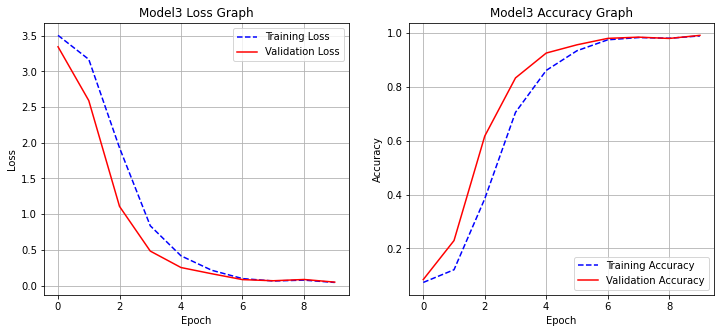

In [39]:
EPOCH = range(10)


plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(EPOCH, hist3.history['loss'], 'b--', label = 'Training Loss')
plt.plot(EPOCH, hist3.history['val_loss'], 'r-', label = 'Validation Loss')
plt.title('Model3 Loss Graph')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend(loc = 'best')

plt.subplot(1, 2, 2)
plt.plot(EPOCH, hist3.history['acc'], 'b--', label = 'Training Accuracy')
plt.plot(EPOCH, hist3.history['val_acc'], 'r-', label = 'Validation Accuracy')
plt.title('Model3 Accuracy Graph')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid()
plt.legend(loc = 'best')

plt.show()

## Modify the Hyperparameter
- Learning_Rate = 1/10 감소 후 재학습

In [41]:
VGG16_model.compile(optimizer = Adam(lr = 0.0001),
                    loss = 'categorical_crossentropy',
                    metrics = ['acc'])

VGG16_model.fit(x_train, y_train, batch_size = 256, epochs = 10, validation_data = (x_val, y_val))

Epoch 1/10
123/123 [==============================] - 8s 64ms/step - loss: 0.0105 - acc: 0.9978 - val_loss: 0.0362 - val_acc: 0.9940
Epoch 2/10
123/123 [==============================] - 8s 63ms/step - loss: 0.0048 - acc: 0.9993 - val_loss: 0.0390 - val_acc: 0.9946
Epoch 3/10
123/123 [==============================] - 8s 63ms/step - loss: 0.0040 - acc: 0.9994 - val_loss: 0.0341 - val_acc: 0.9948
Epoch 4/10
123/123 [==============================] - 8s 63ms/step - loss: 0.0020 - acc: 0.9998 - val_loss: 0.0343 - val_acc: 0.9946
Epoch 5/10
123/123 [==============================] - 8s 63ms/step - loss: 0.0025 - acc: 0.9997 - val_loss: 0.0364 - val_acc: 0.9945
Epoch 6/10
123/123 [==============================] - 8s 64ms/step - loss: 0.0027 - acc: 0.9996 - val_loss: 0.0353 - val_acc: 0.9949
Epoch 7/10
123/123 [==============================] - 8s 62ms/step - loss: 7.6621e-04 - acc: 0.9999 - val_loss: 0.0363 - val_acc: 0.9949
Epoch 8/10
123/123 [==============================] - 8s 62ms/ste

In [43]:
VGG16_model.evaluate(x_test_orig, y_test_orig)

395/395 [==============================] - 3s 6ms/step - loss: 44.0291 - acc: 0.6820


[44.0290641784668, 0.6820269227027893]

# Model4 (ResNet50)

In [56]:
ResNet_base = tf.keras.applications.ResNet50(weights = 'imagenet', include_top = False, input_shape = (32, 32, 3))
ResNet_base.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 38, 38, 3)    0           ['input_7[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 16, 16, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 16, 16, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [57]:
ResNet_model = Sequential([
    ResNet_base,
    
    Flatten(),
    Dense(512, activation = 'relu', kernel_initializer = glorot_uniform()),
    Dropout(0.5),
    Dense(N_CLASSES, activation = 'softmax', kernel_initializer = glorot_uniform())
])

ResNet_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1, 1, 2048)        23587712  
                                                                 
 flatten_9 (Flatten)         (None, 2048)              0         
                                                                 
 dense_17 (Dense)            (None, 512)               1049088   
                                                                 
 dropout_9 (Dropout)         (None, 512)               0         
                                                                 
 dense_18 (Dense)            (None, 43)                22059     
                                                                 
Total params: 24,658,859
Trainable params: 24,605,739
Non-trainable params: 53,120
_________________________________________________________________


In [58]:
ResNet_model.compile(optimizer = Adam(lr = 1e-5),
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

In [63]:
hist4 = ResNet_model.fit(x_train, y_train, batch_size = 256, epochs = 30, validation_data = (x_val, y_val))

Epoch 1/30
123/123 [==============================] - 10s 79ms/step - loss: 0.7243 - acc: 0.7892 - val_loss: 0.6093 - val_acc: 0.8321
Epoch 2/30
123/123 [==============================] - 10s 79ms/step - loss: 0.5854 - acc: 0.8298 - val_loss: 0.4872 - val_acc: 0.8662
Epoch 3/30
123/123 [==============================] - 10s 78ms/step - loss: 0.4722 - acc: 0.8608 - val_loss: 0.4054 - val_acc: 0.8842
Epoch 4/30
123/123 [==============================] - 10s 79ms/step - loss: 0.3734 - acc: 0.8926 - val_loss: 0.3428 - val_acc: 0.9013
Epoch 5/30
123/123 [==============================] - 10s 78ms/step - loss: 0.3052 - acc: 0.9116 - val_loss: 0.2968 - val_acc: 0.9133
Epoch 6/30
123/123 [==============================] - 10s 78ms/step - loss: 0.2437 - acc: 0.9287 - val_loss: 0.2576 - val_acc: 0.9267
Epoch 7/30
123/123 [==============================] - 10s 79ms/step - loss: 0.1936 - acc: 0.9453 - val_loss: 0.2288 - val_acc: 0.9328
Epoch 8/30
123/123 [==============================] - 10s 80ms

In [64]:
ResNet_model.evaluate(x_test_orig, y_test_orig)

395/395 [==============================] - 5s 13ms/step - loss: 1124.9457 - acc: 0.0320


[1124.9456787109375, 0.03198733180761337]

In [66]:
pred = ResNet_model.predict(x_test_orig)
pred[:1]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [71]:
np.argmax(pred[0])

35

### 총 43개의 Classes

In [165]:
df_all = pd.DataFrame(columns = df.columns)
path = "C:/workspace/Data/Traffic-Sign/Train/Images/"
for i in range(43):
    dir = path + format(i, '05d') + '/'
    dir2  = dir + 'GT-' + format(i, '05d') + '.csv'
    df = pd.read_csv(dir2,  sep = ';')
    if i == 0:
         df_all = pd.DataFrame(columns = df.columns)
    df_all = pd.concat([df_all,df])

In [166]:
df_all

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,00000_00000.ppm,29,30,5,6,24,25,0
1,00000_00001.ppm,30,30,5,5,25,25,0
2,00000_00002.ppm,30,30,5,5,25,25,0
3,00000_00003.ppm,31,31,5,5,26,26,0
4,00000_00004.ppm,30,32,5,6,25,26,0
...,...,...,...,...,...,...,...,...
235,00007_00025.ppm,52,56,5,6,47,51,42
236,00007_00026.ppm,56,58,5,5,51,53,42
237,00007_00027.ppm,58,62,5,6,53,57,42
238,00007_00028.ppm,63,69,5,7,58,63,42


C:\Users\User\anaconda3\lib\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


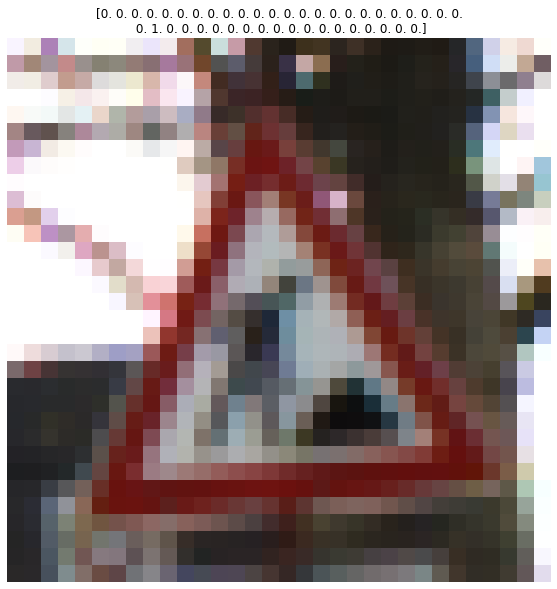

In [91]:
plt.figure(figsize = (10, 10))


plt.imshow(x_train_orig[random_array[90]].astype(np.uint32))
plt.title(y_train_orig[random_array[90]])
plt.axis('off')
plt.show()

In [87]:
random_array = np.random.randint(len(x_train_orig), size = 100)
random_array

array([ 2354, 21972, 23021,  6480,  6374,  4918, 31749, 23794, 32174,
       11528, 29415,   917, 25267, 25209, 33550, 38445, 15961, 29523,
        6412, 36963,  6011, 24721, 24152,   514,  9377, 31257, 23660,
       15028,  7167, 15219, 10665, 23865, 10826,  2594, 26594, 20968,
        5183, 22979,  3616, 36498, 35596, 33333, 35382,  7122, 23235,
        5367, 12084, 32702, 13099, 29373, 28619, 25826, 32008, 31932,
        2219, 18469,  2272, 35682,  1239, 32680, 28738, 24532, 15868,
       19303, 16950, 28440, 25405, 39031, 19261,  5851, 27452,  1960,
        3450, 31127, 23917, 38582,  5353, 11386, 19717, 19670, 14128,
       10177, 38779, 36092, 24784, 13307, 17939, 16664, 27380, 27269,
       29481, 22417, 25687, 34406,  9266,   699, 37997, 29252, 32459,
       25132])

TypeError: Invalid shape (32, 3, 32) for image data

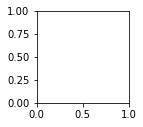

In [89]:
grids = (10, 10)
counter = 0

plt.figure(figsize = (20, 20))

for i in range(0, 100):
    ax = plt.subplot(10, 10, i+1)
    img = np.rollaxis(x_train_orig[random_array[i]].astype(np.uint32), 0, 3)
    ax = plt.imshow(img, cmap = 'gray')
    plt.title(y_train_orig[random_array[i]])
    plt.xticks([])
    plt.yticks([])
    
plt.show()